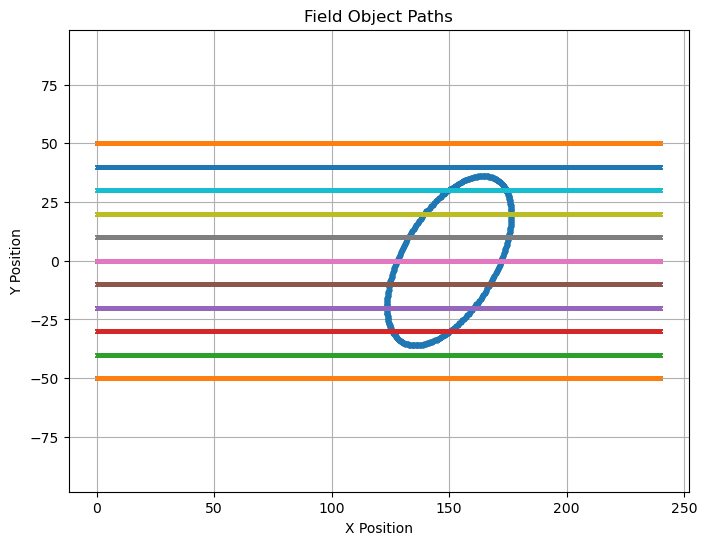

In [1]:
# test_factories.py
import sys
import os

import sys
import os

# In Jupyter Notebook, __file__ is not defined, use os.getcwd() instead
project_root = os.getcwd()

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
from base.factories import create_experiment_setup
from utils.attenuation import inv_sql
import matplotlib.pyplot as plt # Import matplotlib
from visual.plot_paths_arr import plot_paths


# Define a simple experiment dictionary - Increased duration for longer paths
exp_dict = {'time': 120, 'hz': 10, 'trials': 100} # Increased time, higher hz for smoother paths

# Define object dictionaries for new toy problem
obj_dicts = [
    {
        'count': 11,
        'name': 'sensor1',
        'motion': 'linear',
        'motion_params': {
            'start': np.array([[0,10*(i-5)] for i in range(11)]), # Different start positions
            'velocity': np.ones(11)*2,           # Same velocity for parallel paths
            'angle': np.zeros(11)          # Same angle for parallel paths (45 degrees)
        }
    },
    {
        'count': 1,
        'name': 'source1',
        'atten': 'inv_sql',
        'atten_params': {'strength': 10.0, 'scale': 10.0},
        'dist': 'norm',
        'motion': 'elliptical',
        'motion_params': {
            'center': np.array([[150, 0]]), # Center of ellipse
            'periods': 5,              # Increased periods for faster motion
            'a': 40, 'b': 20,           # Ellipse axes
            'phi': np.pi/3            # Ellipse orientation
        }
    }
]

# Create the experiment setup
exp = create_experiment_setup(exp_dict, obj_dicts)
plot_paths(exp.paths)



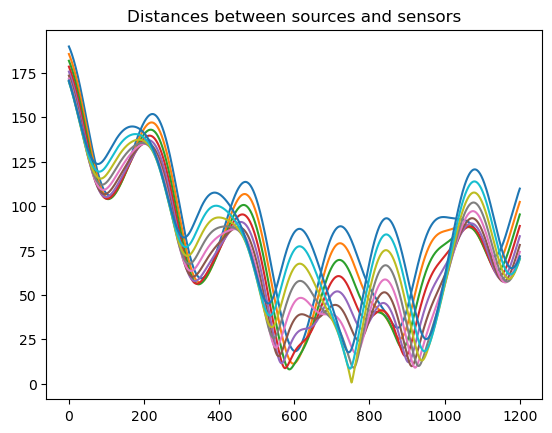

In [3]:
from itertools import product
from utils.math import compute_norm


n_sources = len(exp.sources)
n_sensors = len(exp.sensors)
points = exp.experiment.steps + 1
src_paths = np.array(exp.paths.source_paths)[0]
snsr_paths = np.array(exp.paths.sensor_paths)[0]

distances = np.zeros((n_sources, n_sensors, points))
for i,src in enumerate(src_paths):
    for j,snsr in enumerate(snsr_paths):
        distances[i,j] = np.linalg.norm(src-snsr, axis=-1)

for i,j in product(range(n_sources), range(n_sensors)):
    plt.plot(distances[i,j], label=f'd[{i+1},{j+1}]')
# plt.legend()
plt.title('Distances between sources and sensors')
plt.show()

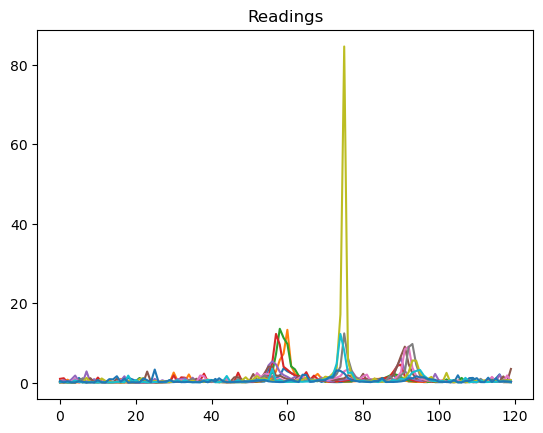

In [6]:
# draw attenuation
from utils.math import simple_path_integral
from functools import partial
from dataclasses import dataclass
from typing import Any
import scipy.stats as stats


def approx_params():
    func = partial(inv_sql, strength=10.0, scale=10.0)
    return simple_path_integral(func, distances)

@dataclass
class NormSampler:
    dist:Any =  stats.norm
    
    def sample(self, approx, trials):
         params = (approx, approx/10)
         return self.dist(*params).rvs(size = (trials, 11,120))
    
s = NormSampler().sample(approx_params(), 100)
b = stats.gamma(0.2).rvs(size = (100, 11,120))
o = s + b

i = 0
t = np.arange(0, 120)
for a,b in enumerate(o[i]):
    plt.plot(t, b, label = f'Sensor {a+1}')

plt.title('Readings')
plt.show()

In [56]:
np.array(exp.paths.sensor_paths).shape

(2, 2, 201, 2)